In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
_include_('curriculum_vqa')

from cvqa.curriculum import plotter, VQAInstanceDistribution2
from cvqa import trainers, datasets, viz

concept_dict = {
        'color': ['blue', 'brown', 'cyan', 'gray'],  # , 'green', 'purple', 'red', 'yellow'],
        'material': ['metal', 'rubber', 'plastic'],
        'shape': ['triangle', 'circle', 'square']
    }

# vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, prompt_types_filter=['retrieve_attribute'], d_img=16)
# vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, prompt_types_filter=['exists', 'retrieve_attribute'], d_img=16)
vqa_dist = VQAInstanceDistribution2(concept_dict=concept_dict, max_ref_concepts=3, d_img=24)

Img Encoder: Loss=0.001: 100%|██████████| 10/10 [00:03<00:00,  2.94it/s]


In [3]:
# ds_temp = vqa_dist.sample_dataset(images=20, prompts_per_image=3)
# VQAInstanceDistribution2.to_debug_rep(ds_temp)

In [4]:
import random
import numpy as np
import torch
import torch.nn as nn

seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

ds_train, ds_dev = datasets.Curriculum.from_samples(
    vqa_dist.sample_dataset(images=1000, prompts_per_image=5),
    vqa_dist.sample_dataset(images=100, prompts_per_image=5),
)

ds_train

Root: - 
Samples: 2930 (N_prompt=9, N_target=1)
Concepts: 0 
Classes: 0 
Prompt Vocab Tokens:42 
Answer Vocab Tokens:22 

In [5]:
trainer = trainers.VQATrainer(
#     log_dir='runs',
    loss_fn=nn.NLLLoss(ignore_index=-1), 
    pred_target='target_attention_mask', 
    ignore_index=-1
)

def train_model(model, lr=1e-4, epochs=10, batch_size=32):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=300, gamma=0.1)
    
#     tracker = None
#     tracker = traintracks.TrainTracker(root='traintracks/eval')
#     tracker.save_module(sys.modules['cvqa.model_dev.f1_model'])
#     tracker.log_conf(model.args)

    train_loss, train_acc, dev_acc = trainer.train(
        model, ds_train, ds_dev, 
        optimizer, 
#         optim_sched=scheduler,
        num_epochs=epochs, 
        batch_size=batch_size
    )
    
    return {
        'train_loss': train_loss, 
        'train_acc': train_acc, 
        'dev_acc': dev_acc
    }

[epoch=4, steps=454, train_acc=0.94, dev_acc=0.93] loss: 0.101: 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]


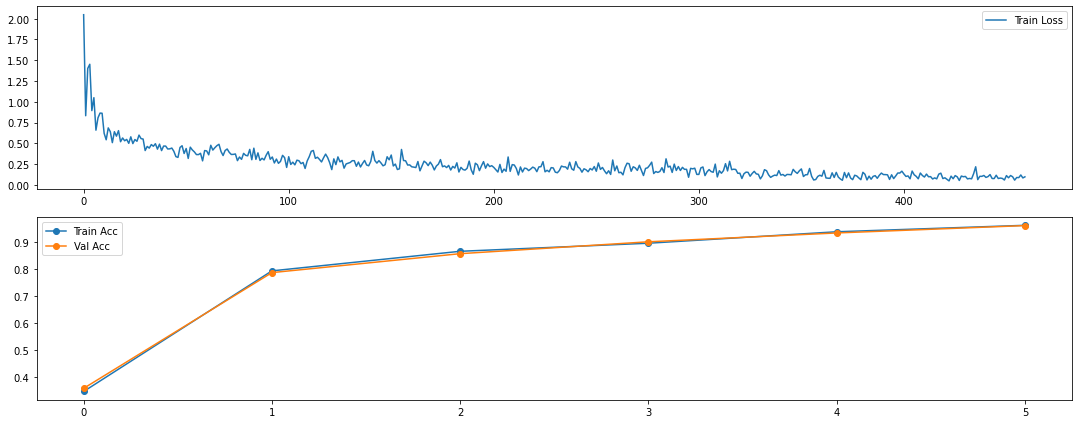

In [13]:
import numpy as np
from cvqa.model_dev import f1_model

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)

args = f1_model.default_args()
args['d_a'] = 4
args['d_w'] = args['d_c'] = 32
args['d_o'] = 24
args['d_k'] = 4
    
model = f1_model.ParentModel(ds_train.vocab, ds_train.ans_vocab, args)

# print(trainer.evaluate(model, torch.utils.data.DataLoader(ds_train, batch_size=32)))

train_metrics = train_model(model, lr=3e-3, epochs=5, batch_size=32)

viz.plot_training(**train_metrics)

In [7]:
# print(trainer.evaluate(model, torch.utils.data.DataLoader(ds_dev, batch_size=32)))


In [8]:
# y_true, y_pred = trainer.get_predictions(model, ds_dev)
# viz.one_word_conf_mat(y_true, y_pred, ds_dev.ans_vocab)

In [9]:
np.set_printoptions(precision=2, suppress=True)

def show_some_predictions(ds, count=3):
    ds_with_idxs = datasets.WithIndicesDataset(ds)
    loader = torch.utils.data.DataLoader(ds_with_idxs, batch_size=1)
    with torch.no_grad():
        for i, s in enumerate(loader):
            if i >= count:
                break
            probs = model.forward_test(s)[1]
            full_sample = ds.samples[s['index']]
            print(full_sample['debug_info']['SCENE '])
            print(full_sample['debug_info']['PROMPT'])
            print('TRUE: ' + str(s['target_attention_mask'].numpy().flatten()))
            print('PRED: ' + str(probs.numpy().flatten()))
            print()
        
show_some_predictions(ds_train)

[['0' 'blue rubber triangle']
 ['1' 'gray rubber circle']]
How many gray rubber circles are there ? --> 1
TRUE: [ 0  1 -1 -1 -1 -1 -1]
PRED: [0.   0.98 0.   0.   0.   0.   0.  ]

[['1' 'blue rubber triangle']
 ['0' 'gray rubber circle']]
What material is the blue triangle ? --> rubber
TRUE: [ 1  0 -1 -1 -1 -1 -1]
PRED: [0.94 0.   0.   0.   0.   0.   0.  ]

[['0' 'blue rubber triangle']
 ['0' 'gray rubber circle']]
Are there 1 metal items ? --> False
TRUE: [ 0  0 -1 -1 -1 -1 -1]
PRED: [0. 0. 0. 0. 0. 0. 0.]

